NEMA3 PDE=0.3, sigmaT = 50 ps, LXe = 40 mm, SiPM_qmin = 1 pe

- Phantom : nema 3
- Events: all
- Detector geometry: SiPMs in LXe, with Hamamatsu sipms
- Time resolution: 50 ps
- qcut > 1 pes
- ntof > 7
- PDE = 0.3
- LXe = 40 mm

In [1]:
using Pkg
Pkg.activate(normpath(joinpath(@__DIR__, "..")))  #activate environment

  Activating environment at `~/FiB/reco_code/ANema/Project.toml`


In [2]:
using Plots
using DataFrames
using HDF5
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful
using Glob
using CSV
using Statistics
using StatsBase
using Printf
using Logging
using ATools

In [3]:
include("../src/ANema.jl")

Main.ANema

In [4]:
import Unitful: nm, μm, mm, cm, ns, μs, ms, ps, s

In [5]:
## Set the input out put directories and the files to be read
norm = 5.0e+6 ## Hardwired seems unstable, possible to put in files or a database?
in_dir    = "../../data/"
config    = "n3-40mm-qcut1"
plot_dir  = "plot_dir"
if !isdir(plot_dir)
  mkdir(plot_dir)
end
in_path   = joinpath(in_dir, config)
plot_path = joinpath(plot_dir, config)
if !isdir(plot_path)
  mkdir(plot_path)
end

"plot_dir/n3-40mm-qcut1"

In [6]:
ndf = ANema.readdf(in_path) 
println("data frame has length of ", nrow(ndf), " fraction =", nrow(ndf)/norm)
println("data frame names ", names(ndf))

data frame has length of 797877 fraction =0.1595754
data frame names ["corrzphi1", "corrzphi2", "nsipm1", "nsipm2", "phistd1", "phistd2", "phot1", "phot2", "q1", "q2", "r1", "r2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "widphi1", "widphi2", "widz1", "widz2", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2"]


## q1 vs q2

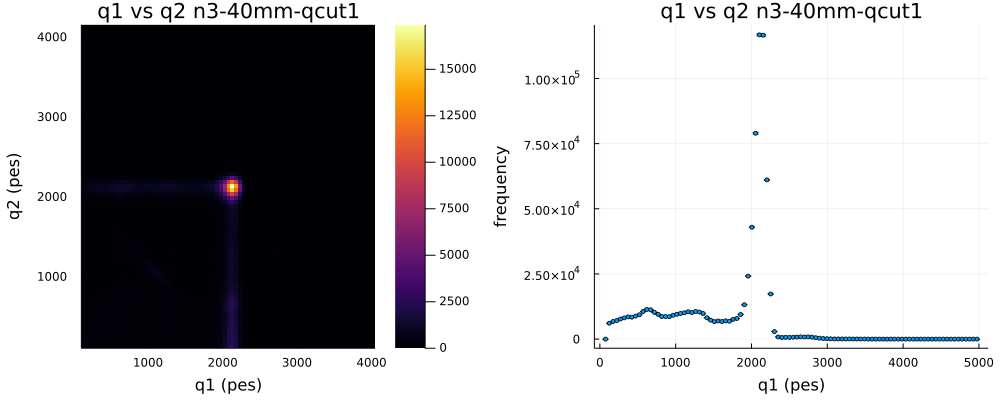

In [8]:
ANema.ANema.q1vsq2(ndf, tit="q1 vs q2 $config", filename=joinpath(plot_path, "q1q2"), save=true)

## Select photoelectric energy region

after q1q2 cut: ndfq has a length of 246581 fraction = 0.0493162


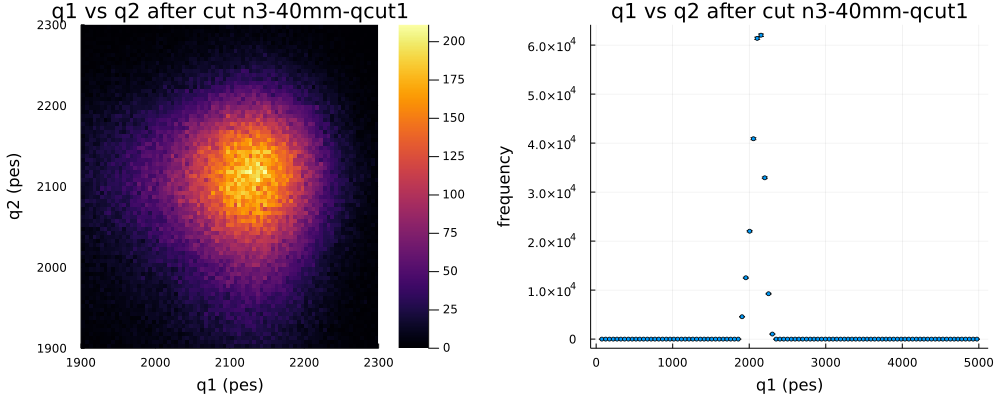

In [10]:
wmin = 1900.0
wmax = 2300.0
ndfq =ANema.selectinterval(ndf, "q1", "q2", wmin, wmax);
println("after q1q2 cut: ndfq has a length of ", nrow(ndfq), " fraction = ", nrow(ndfq)/norm)
ANema.q1vsq2(ndfq, tit="q1 vs q2 after cut $config", 
filename=joinpath(plot_path, "q1q2-qcut"), save=true)

## For the purposes of calibration, hemisphere 1 and hemisphere 2 give the same data. Combine relevant columns (zstd(1, 2), phistd(1, 2), r(1, 2), nsipm(1, 2)...

In [11]:
ring_df = DataFrame(r=vcat(ndfq.r1, ndfq.r2), nsipm=vcat(ndfq.nsipm1, ndfq.nsipm2), zstd=vcat(ndfq.zstd1, ndfq.zstd2), phistd=vcat(ndfq.phistd1, ndfq.phistd2))
println("Combined dataframe has ", nrow(ring_df), "rows.")

Combined dataframe has 493162rows.


In [12]:
## Add a column combining the two std measures in a radius using the sipm position.
sipm_r = 392.4
ring_df[!, "stdrad"] = sqrt.(ring_df.zstd.^2 + (sipm_r * tan.(ring_df.phistd)).^2)

493162-element Vector{Float64}:
  54.13223102960633
 160.3926060325412
  48.97509746970494
 560.5735841885456
  34.283733874516
  50.767419199754286
 201.85799060342046
  84.76510880211103
  51.67213166795022
  37.94502341381095
  58.46087786387511
 793.7644218225386
  41.157471078901324
   ⋮
  48.28368070431066
  40.35268269983444
  26.409999012132126
  49.374374181562516
  71.74363324937511
  36.005833284187815
 149.24173045886545
  47.54202186503184
  26.40745667336129
  33.66801152544817
  70.66679237837003
  26.058377254948994

## Correlations between the size of the area of charge seen and the interaction radius

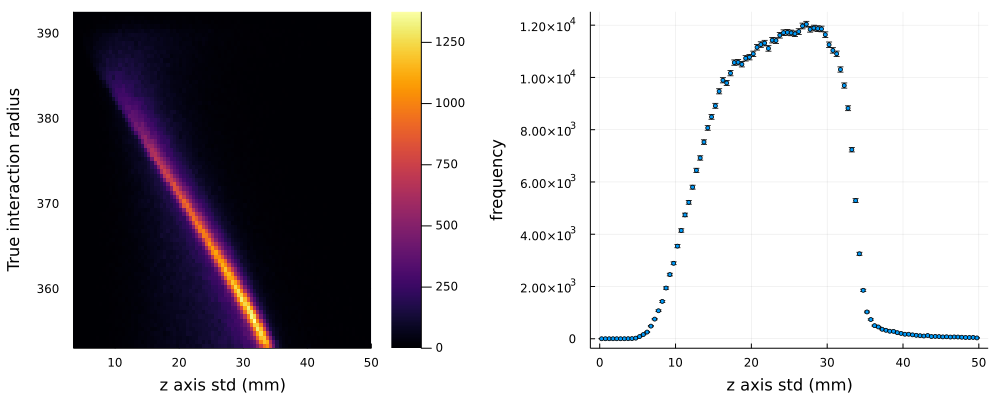

In [13]:
hzr, pzr = hist2d(ring_df.zstd, ring_df.r, 100, "z axis std (mm)", "True interaction radius", 0.0, 50.0, 350.0, 400.0)
hz , pz  = hist1d(ring_df.zstd, "z axis std (mm)", 100, 0.0, 50.0)
ANema.condplot(pzr, pz, " r = f(σz) $config", "", false)

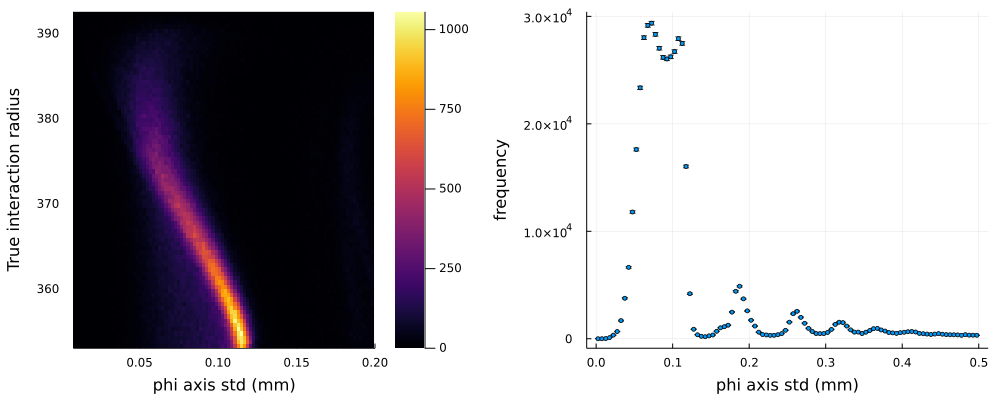

In [14]:
hpr, ppr = hist2d(ring_df.phistd, ring_df.r, 100, "phi axis std (mm)", "True interaction radius", 0.0, 0.2, 350.0, 400.0)
hp , pp  = hist1d(ring_df.phistd, "phi axis std (mm)", 100, 0.0, 0.5)
ANema.condplot(ppr, pp, " r = f(σϕ) $config", "", false)

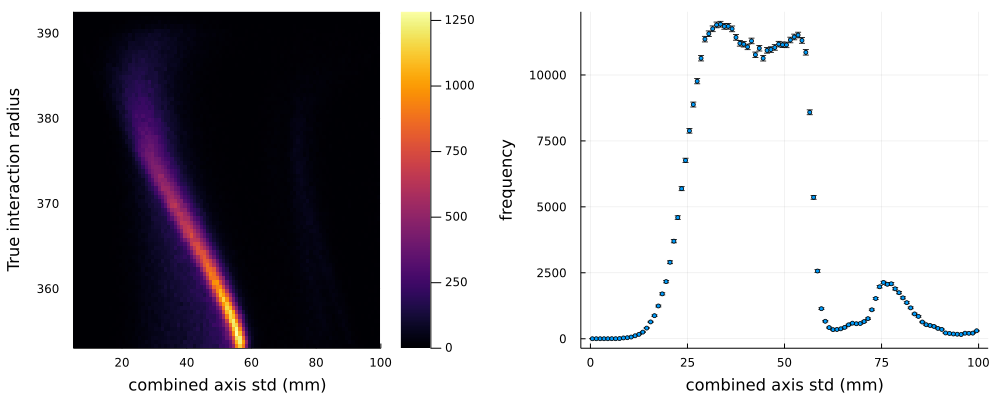

In [15]:
hcr, pcr = hist2d(ring_df.stdrad, ring_df.r, 100, "combined axis std (mm)", "True interaction radius", 0.0, 100.0, 350.0, 400.0)
hc , pc  = hist1d(ring_df.stdrad, "combined axis std (mm)", 100, 0.0, 100.0)
ANema.condplot(pcr, pc, " r = f(σcomb) $config", "", false)

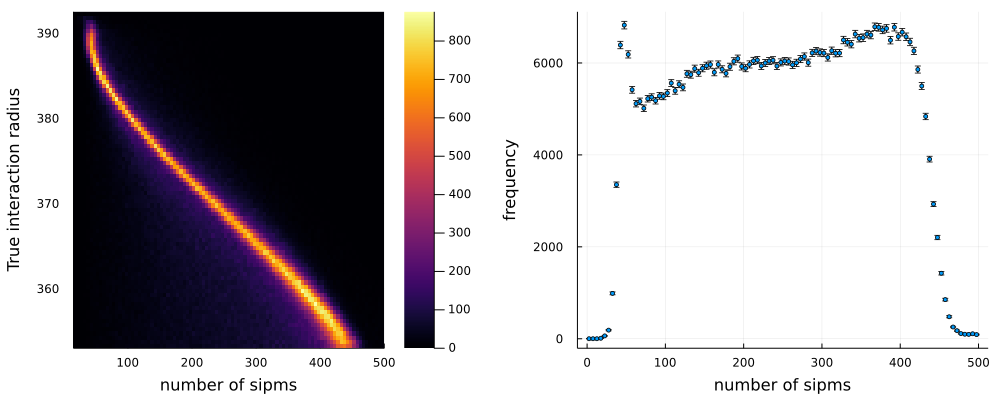

In [16]:
hnr, pnr = hist2d(Float64.(ring_df.nsipm), ring_df.r, 100, "number of sipms", "True interaction radius", 0.0, 500.0, 350.0, 400.0)
hn , pn  = hist1d(Float64.(ring_df.nsipm), "number of sipms", 100, 0.0, 500.0)
ANema.condplot(pnr, pn, " r = f(nsipm) $config", "", false)

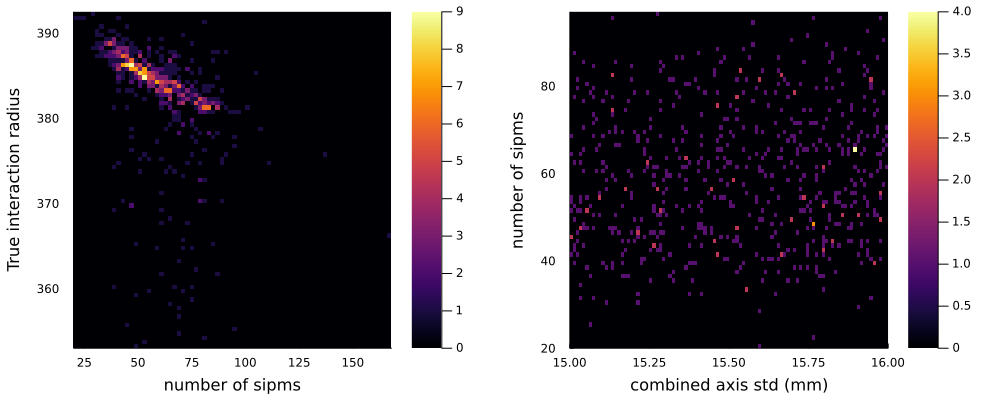

In [17]:
## Look at a specific 'bin' in the combined std
mask_std = (ring_df.stdrad .>= 15) .& (ring_df.stdrad .< 16)
hncr, pncr = hist2d(Float64.(ring_df[mask_std, "nsipm"]), ring_df[mask_std, "r"], 100, "number of sipms", "True interaction radius", 0.0, 500.0, 350.0, 400.0)
hnc , pnc  = hist2d(ring_df[mask_std, "stdrad"], Float64.(ring_df[mask_std, "nsipm"]), 100, "combined axis std (mm)", "number of sipms", 0.0, 500.0, 0.0, 100.0)
ANema.condplot(pncr, pnc, " r = f(nsipm) $config", "", false)

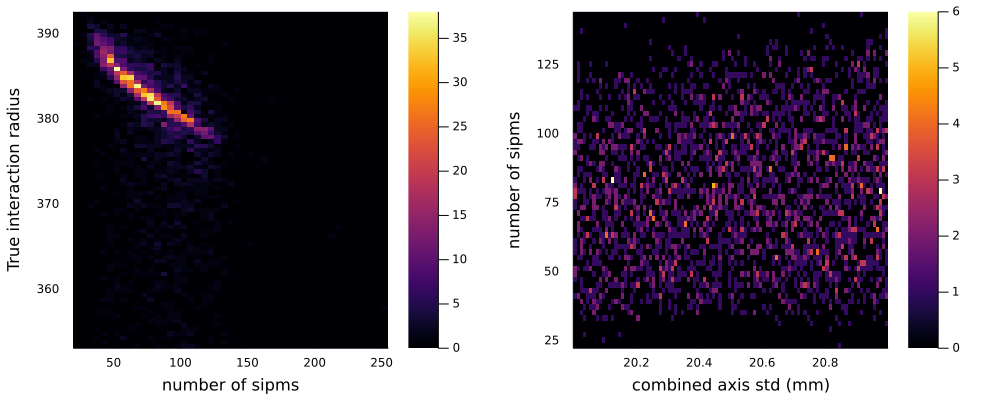

In [18]:
## Look at a specific 'bin' in the combined std
mask_std = (ring_df.stdrad .>= 20) .& (ring_df.stdrad .< 21)
hncr, pncr = hist2d(Float64.(ring_df[mask_std, "nsipm"]), ring_df[mask_std, "r"], 100, "number of sipms", "True interaction radius", 0.0, 500.0, 350.0, 400.0)
hnc , pnc  = hist2d(ring_df[mask_std, "stdrad"], Float64.(ring_df[mask_std, "nsipm"]), 100, "combined axis std (mm)", "number of sipms", 0.0, 500.0, 0.0, 150.0)
ANema.condplot(pncr, pnc, " r = f(nsipm) $config", "", false)

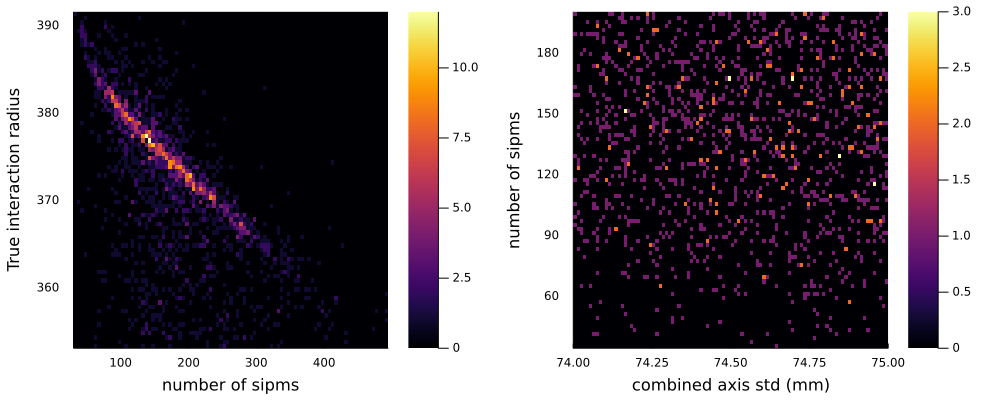

In [19]:
## Look at a specific 'bin' in the combined std
mask_std = (ring_df.stdrad .>= 74) .& (ring_df.stdrad .< 75)
hncr, pncr = hist2d(Float64.(ring_df[mask_std, "nsipm"]), ring_df[mask_std, "r"], 100, "number of sipms", "True interaction radius", 0.0, 500.0, 350.0, 400.0)
hnc , pnc  = hist2d(ring_df[mask_std, "stdrad"], Float64.(ring_df[mask_std, "nsipm"]), 100, "combined axis std (mm)", "number of sipms", 0.0, 500.0, 0.0, 200.0)
ANema.condplot(pncr, pnc, " r = f(nsipm) $config", "", false)

# Make a selection in the zstd
and look at dependence in of r (DOI - sipm_r) with the parameters

In [24]:
mask_std = (ring_df.zstd .>= 3.0) .& (ring_df.zstd .< 35.0)
println("Masking keeps ", 100 * count(mask_std) / nrow(ring_df), "% of the interactions")

Masking keeps 98.40397273107011% of the interactions


Fit parameters: a = 393.49 b = -1.14 Fit errors: a =   0.2 b = 0.0099

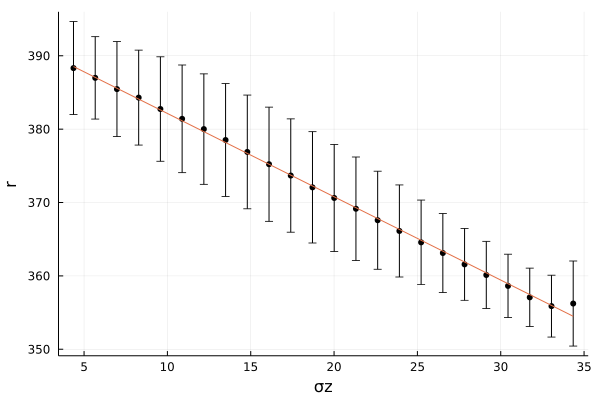

In [25]:
fzr, pzr = fit_profile(ring_df[mask_std, "zstd"], ring_df[mask_std, "r"], "σz", "r", "pol1")
fpars = fzr.fitpar
fstds = fzr.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr)

Fit parameters: a = 365.59 b =  0.47 Fit errors: a =     1 b =  0.47

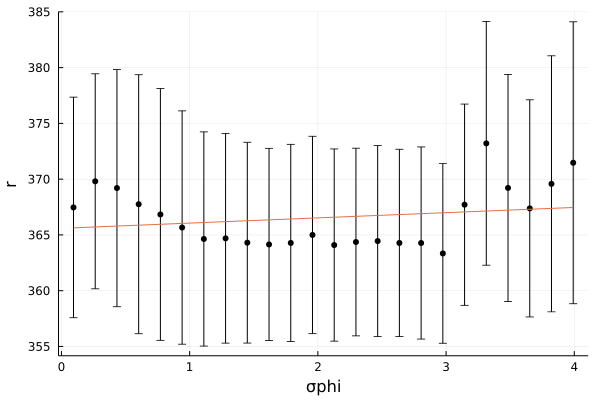

In [26]:
## phi
fpr, ppr = fit_profile(ring_df[mask_std, "phistd"], ring_df[mask_std, "r"], "σphi", "r", "pol1")
fpars = fpr.fitpar
fstds = fpr.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(ppr)

Fit parameters: a = 372.87 b = -0.03 Fit errors: a =     2 b =  0.02

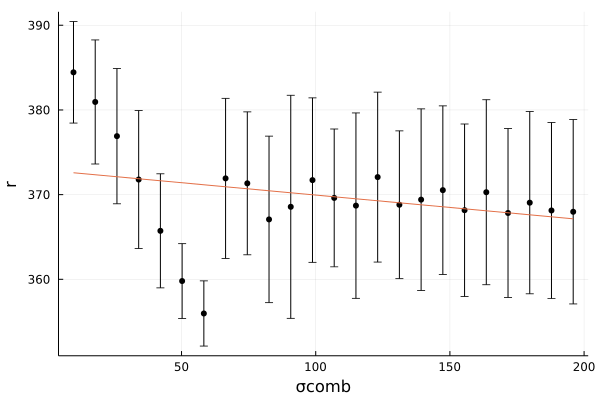

In [28]:
## comb. Needs an additional limit on itself to avoid errors
patch_mask = mask_std .& (ring_df.stdrad .< 200)
fcr, pcr = fit_profile(ring_df[patch_mask, "stdrad"], ring_df[patch_mask, "r"], "σcomb", "r", "pol1")
fpars = fcr.fitpar
fstds = fcr.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pcr)

# Masking with phi std?


In [29]:
mask_std = (ring_df.phistd .>= 0.025) .& (ring_df.phistd .< 0.12)
println("Masking keeps ", 100 * count(mask_std) / nrow(ring_df), "% of the interactions")

Masking keeps 77.87501875651408% of the interactions


Fit parameters: a = 392.52 b = -307.58 Fit errors: a =   0.5 b =   6.1

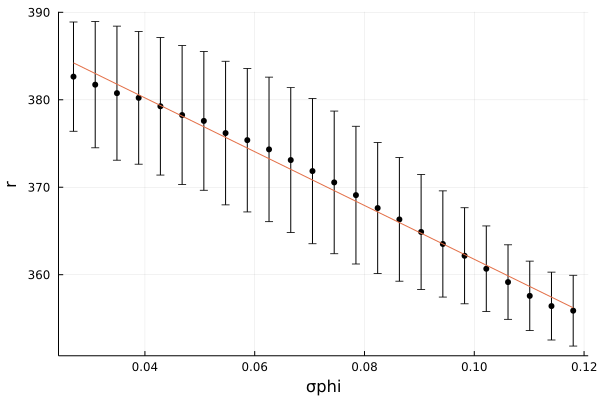

In [30]:
fpr2, ppr2 = fit_profile(ring_df[mask_std, "phistd"], ring_df[mask_std, "r"], "σphi", "r", "pol1")
fpars = fpr2.fitpar
fstds = fpr2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(ppr2)

Fit parameters: a = 377.37 b = -0.27 Fit errors: a =     3 b = 0.066

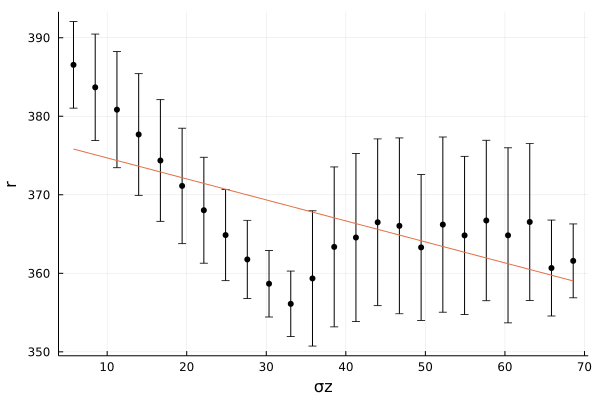

In [32]:
## zstd
## Needs a patch too.
patch_mask = mask_std .& (ring_df.zstd .< 70)
fzr2, pzr2 = fit_profile(ring_df[patch_mask, "zstd"], ring_df[patch_mask, "r"], "σz", "r", "pol1")
fpars = fzr2.fitpar
fstds = fzr2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr2)

Fit parameters: a = 394.18 b = -0.67 Fit errors: a =   0.3 b =  0.01

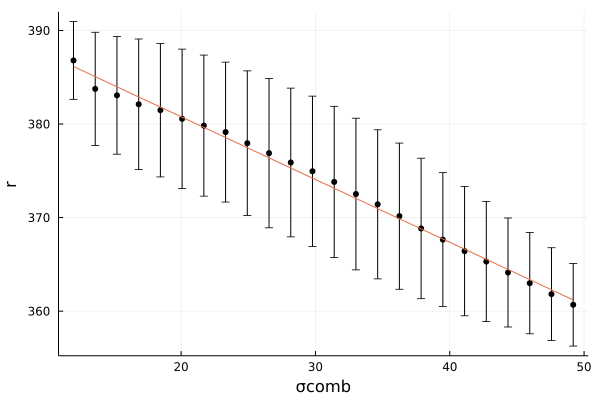

In [34]:
## comb. Needs an additional limit on itself to avoid errors
patch_mask = mask_std .& (ring_df.stdrad .< 50)
fcr2, pcr2 = fit_profile(ring_df[patch_mask, "stdrad"], ring_df[patch_mask, "r"], "σcomb", "r", "pol1")
fpars = fcr2.fitpar
fstds = fcr2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pcr2)

# Masking with combined std

In [41]:
mask_std = (ring_df.stdrad .>= 10.0) .& (ring_df.stdrad .< 60.0)
println("Masking keeps ", 100 * count(mask_std) / nrow(ring_df), "% of the interactions")

Masking keeps 79.37006500906396% of the interactions


Fit parameters: a = 393.38 b = -0.65 Fit errors: a =   0.4 b = 0.012

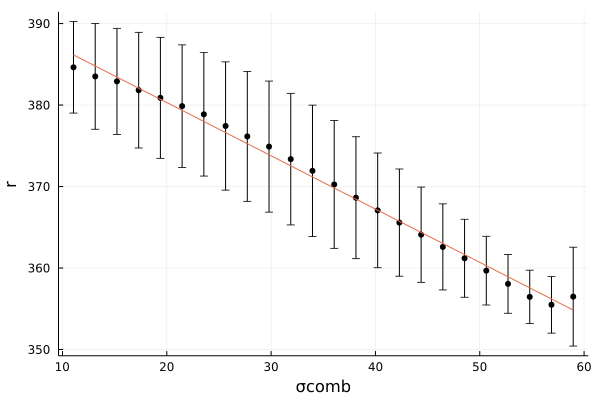

In [42]:
fcr3, pcr3 = fit_profile(ring_df[mask_std, "stdrad"], ring_df[mask_std, "r"], "σcomb", "r", "pol1")
fpars = fcr3.fitpar
fstds = fcr3.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pcr3)

Fit parameters: a = 379.15 b = -0.33 Fit errors: a =     4 b =  0.11

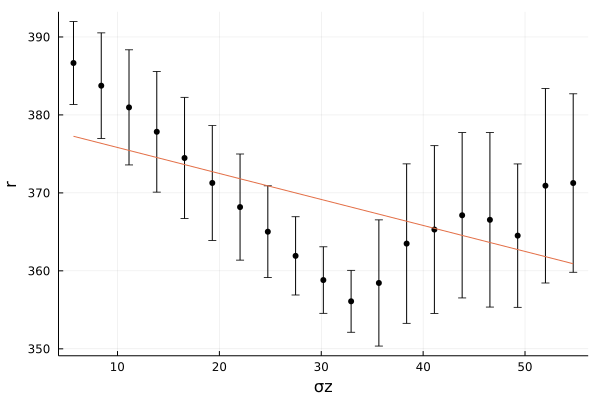

In [43]:
## zstd
fzr3, pzr3 = fit_profile(ring_df[mask_std, "zstd"], ring_df[mask_std, "r"], "σz", "r", "pol1", 20)
fpars = fzr3.fitpar
fstds = fzr3.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr3)

In [44]:
## phi
fpr3, ppr3 = fit_profile(ring_df[mask_std, "phistd"], ring_df[mask_std, "r"], "σphi", "r", "pol1")
fpars = fpr3.fitpar
fstds = fpr3.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(ppr3)

LoadError: ArgumentError: New columns must have the same length as old columns

## Check the predicted R for all events using the fit from selection on each parameter (best always when select on the specific parameter)

In [45]:
ring_df[!, "rpredz"] = fzr.g.(ring_df.zstd)
ring_df[!, "rpredp"] = fpr2.g.(ring_df.phistd)
ring_df[!, "rpredc"] = fcr3.g.(ring_df.stdrad)

493162-element Vector{Float64}:
  357.99383238285054
  288.5363770996729
  361.364810262576
   26.95672057501571
  370.9678700102341
  360.1932530719061
  261.4323875405163
  337.97054771045947
  359.60188469209265
  368.5746556587195
  355.16439766723255
 -125.46926302387959
  366.4748283238226
    ⋮
  361.8167571812942
  367.00088098315035
  376.1145635646331
  361.1038216827908
  346.4820794634781
  369.8422138779537
  295.8251848185001
  362.30154500237194
  376.1162253730117
  371.3703390164469
  347.1859601588254
  376.3444023213236

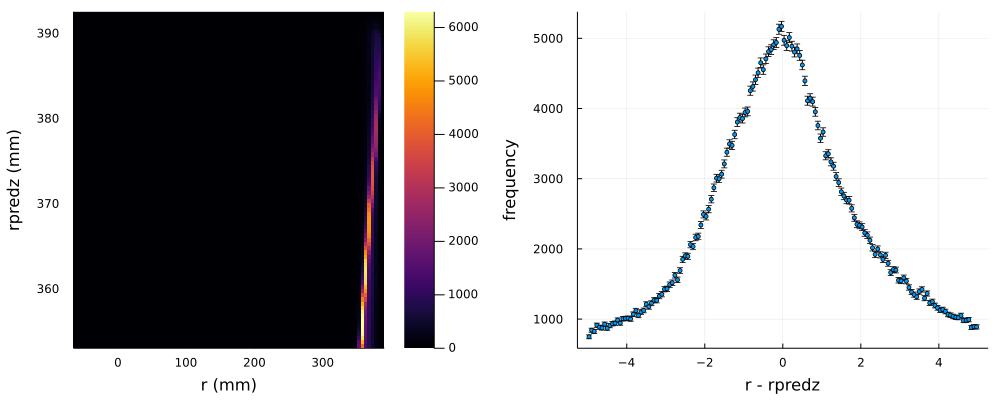

In [46]:
ANema.plotreso(ring_df.r, ring_df.rpredz, "r (mm)", "rpredz (mm)", -5., 5.0, tit="r - rpredz", filename=filename=joinpath(plot_path, "r-rpredz"), save=false)

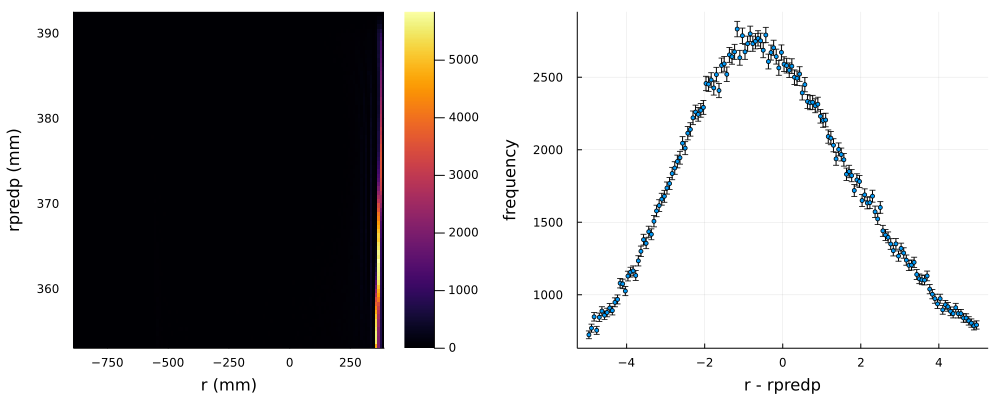

In [47]:
ANema.plotreso(ring_df.r, ring_df.rpredp, "r (mm)", "rpredp (mm)", -5., 5.0, tit="r - rpredp", filename=filename=joinpath(plot_path, "r-rpredp"), save=false)

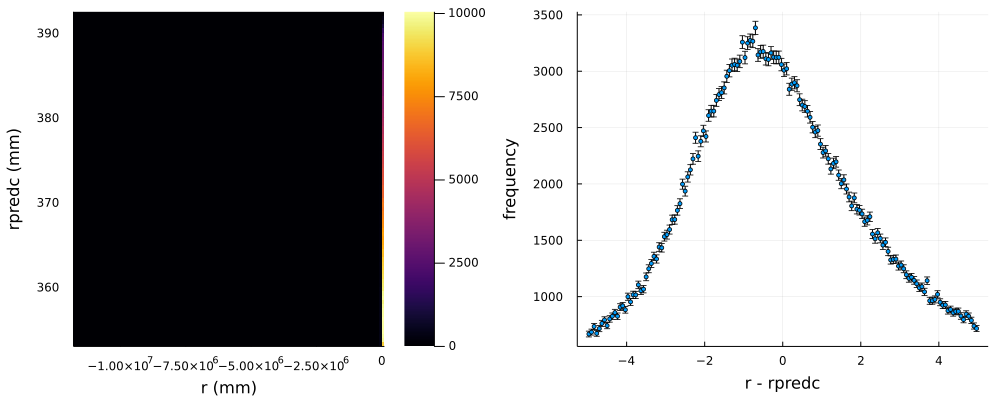

In [48]:
ANema.plotreso(ring_df.r, ring_df.rpredc, "r (mm)", "rpredc (mm)", -5., 5.0, tit="r - rpredc", filename=filename=joinpath(plot_path, "r-rpredc"), save=false)

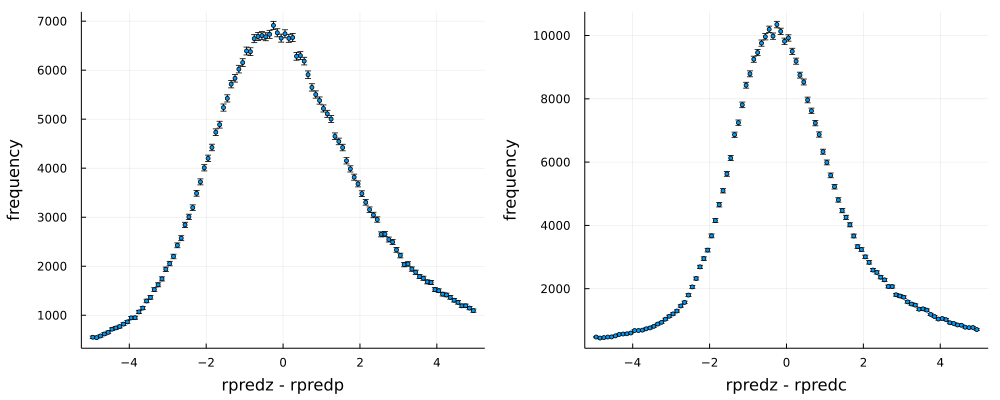

In [49]:
## Difference in predictions
diff1, pdiff1 = hist1d(ring_df.rpredz - ring_df.rpredp, "rpredz - rpredp", 100, -5.0, 5.0)
diff2, pdiff2 = hist1d(ring_df.rpredz - ring_df.rpredc, "rpredz - rpredc", 100, -5.0, 5.0)
ANema.condplot(pdiff1, pdiff2, "Diff predictions", "", false)

# Not so much bias in this dataset but have a look at the correlations anyway

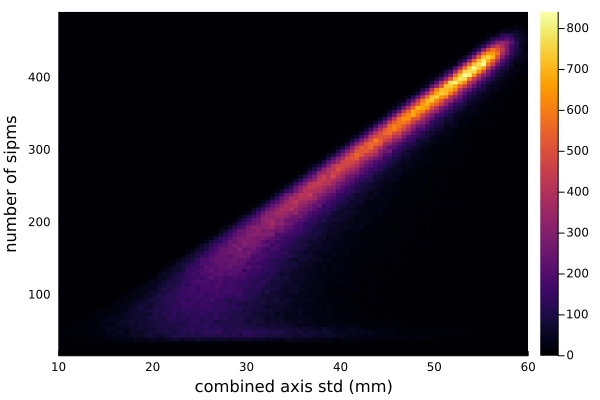

In [50]:
hnc , pnc  = hist2d(ring_df[mask_std, "stdrad"], Float64.(ring_df[mask_std, "nsipm"]), 100, "combined axis std (mm)", "number of sipms", 0.0, 500.0, 0.0, 500.0)
plot(pnc)
#x1 = 10:0.72:28
#y1 = 8.0 .* x1 .- 60.0
#plot!(plot(x1, y1))

Check proportions: 324180, 391423, 0.8282088686663789


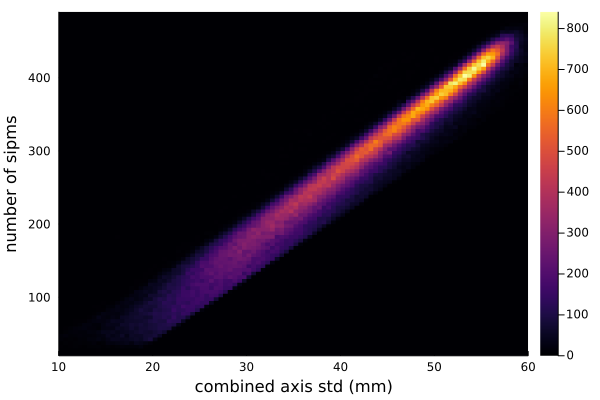

In [55]:
nsipm_mask = mask_std .& (ring_df.nsipm .> 8.5 .* ring_df.stdrad .- 130.0)
#nsipm_mask = mask_std .& (ring_df.nsipm .> 40.0)
println("Check proportions: ", count(nsipm_mask), ", ", count(mask_std), ", ", count(nsipm_mask) / count(mask_std))
hnc2 , pnc2  = hist2d(ring_df[nsipm_mask, "stdrad"], Float64.(ring_df[nsipm_mask, "nsipm"]), 100, "combined axis std (mm)", "number of sipms", 0.0, 500.0, 0.0, 500.0)
plot(pnc2)

In [61]:
## Try
mask_std2 = (ring_df.stdrad .>= 10.0) .& (ring_df.stdrad .< 60.0) .& (ring_df.nsipm .> 40.0)
#mask_std2 = (ring_df.stdrad .>= 10.0) .& (ring_df.stdrad .< 60.0) .& (ring_df.nsipm .> 8.5 .* ring_df.stdrad .- 130.0)
println("Masking keeps ", 100 * count(mask_std2) / nrow(ring_df), "% of the interactions")

Masking keeps 78.50564317607602% of the interactions


Fit parameters: a = 392.69 b = -0.64 Fit errors: a =   0.5 b = 0.013

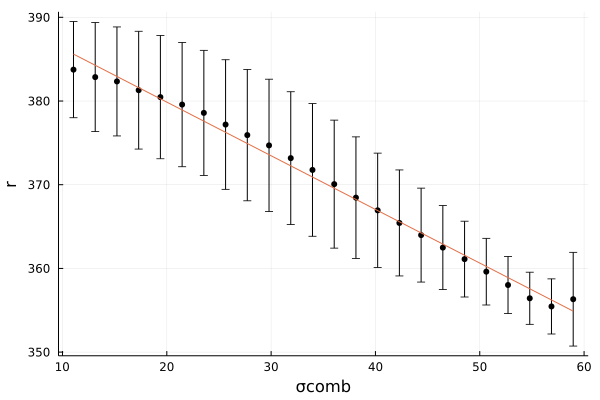

In [62]:
fcr4, pcr4 = fit_profile(ring_df[mask_std2, "stdrad"], ring_df[mask_std2, "r"], "σcomb", "r", "pol1")
fpars = fcr4.fitpar
fstds = fcr4.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pcr4)

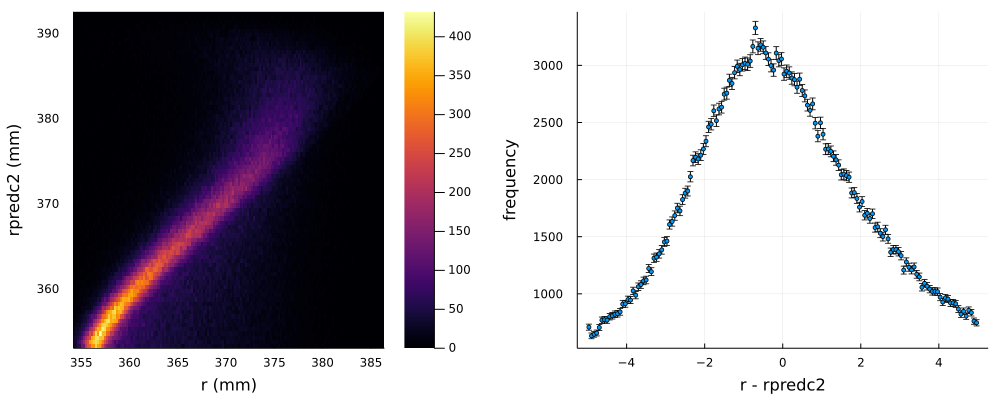

In [63]:
ring_df[!, "rpredc2"] = fcr4.g.(ring_df.stdrad)
ANema.plotreso(ring_df[mask_std2, "r"], ring_df[mask_std2, "rpredc2"], "r (mm)", "rpredc2 (mm)", -5., 5.0, tit="r - rpredc2", filename=filename=joinpath(plot_path, "r-rpredc2"), save=false)

 σ =     2.7 mm

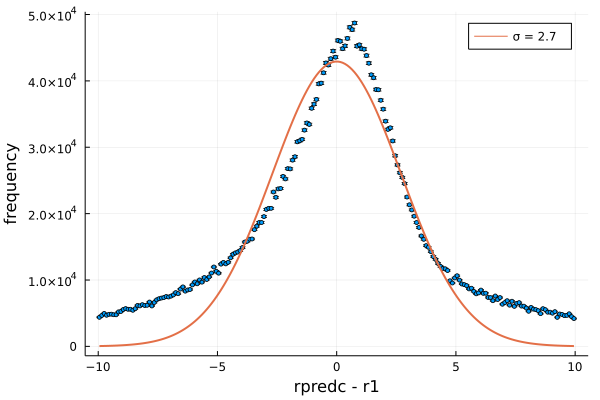

In [64]:
rpredc = ring_df[mask_std2, "rpredc2"]
mask_r = ring_df[mask_std2, "r"]
fg,p = fitg1(rpredc - mask_r, "rpredc - r1", 200, -10.0, 10.0, xgmin=-5.5, xgmax=5.5)
@printf " σ = %7.1f mm" fg.std[1] 
#ANema.pout(p,joinpath(pathp, "zstd-fitg1"))
plot(p)

In [65]:
## Add r predictions to original df
ndfq[!, "stdrad1"] = sqrt.(ndfq.zstd1.^2 + (sipm_r * tan.(ndfq.phistd1)).^2)
ndfq[!, "rpred1"] = fcr4.g.(ndfq.stdrad1)
ndfq[!, "stdrad2"] = sqrt.(ndfq.zstd2.^2 + (sipm_r * tan.(ndfq.phistd2)).^2)
ndfq[!, "rpred2"] = fcr4.g.(ndfq.stdrad2)

246581-element Vector{Float64}:
  359.744590819702
  371.56748259266624
  368.568656139902
  359.4171441248688
  373.58774920599313
 -616.7441667353191
  373.438274883188
  371.4956022537021
  360.91337345211986
  382.3493247665042
 -140.89965834085825
  361.8040492286335
  371.32604024773747
    ⋮
  361.73517103520504
  366.8199954021922
  375.75910971244787
  361.03589147834293
  346.6942218025638
  369.6069039117932
  297.0076359701696
  362.21067297529225
  375.76073968967444
  371.10575853737794
  347.38461999673353
  375.98454601666566

In [66]:
mask = (ndfq.stdrad1 .>= 10.0) .& (ndfq.stdrad1 .< 60.0) .& (ndfq.nsipm1 .> 40.0) .& (ndfq.stdrad2 .>= 10.0) .& (ndfq.stdrad2 .< 60.0) .& (ndfq.nsipm2 .> 40.0)
ndf_mask = ndfq[mask, :]
println("after masking cut: ndf_mask has a length of ", nrow(ndf_mask), " fraction = ", nrow(ndf_mask)/norm)

after masking cut: ndf_mask has a length of 142780 fraction = 0.028556


## Best estimators

In [67]:
xp1,yp1,zp1 = ANema.radial_correction(ndf_mask.xr1, ndf_mask.yr1, ndf_mask.zr1, ndf_mask.rpred1);
xp2,yp2,zp2 = ANema.radial_correction(ndf_mask.xr2, ndf_mask.yr2, ndf_mask.zr2, ndf_mask.rpred2);

In [68]:
fg,px1 = fitg1(ndf_mask.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,py1 = fitg1(ndf_mask.yt1 - yp1, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pz1 = fitg1(ndf_mask.zt1 - zp1, "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]

 σx1 =  1.85 mm σy1 =  2.22 mm σz =  0.99 mm

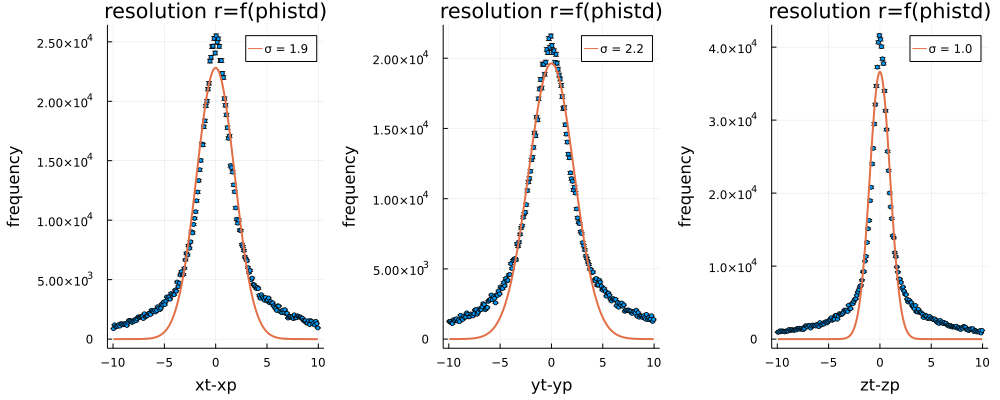

In [69]:
ANema.plot_and_save(px1,py1, pz1, "resolution r=f(phistd)", joinpath(plot_path, "phistd-res"))

x-x(rphi) σ1 =   4.506 σ2 =   1.252y-y(rphi) σ1 =   5.013 σ2 =   1.568z-z(rphi) σ1 =   3.771 σ2 =   0.707

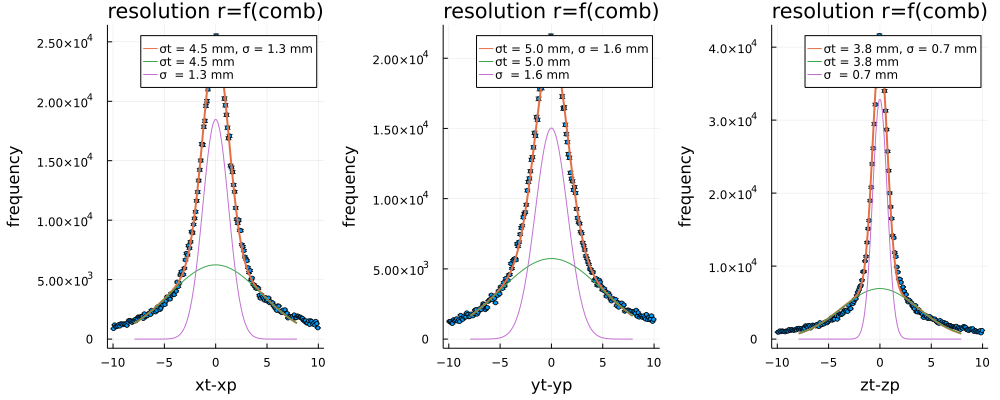

In [70]:
fg, px = fitg2(ndf_mask.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "x-x(rphi) σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]

fg, py = fitg2(ndf_mask.yt1 - yp1, "yt-yp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "y-y(rphi) σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]

fg, pz = fitg2(ndf_mask.zt1 - zp1, "zt-zp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "z-z(rphi) σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]
ANema.plot_and_save(px,py, pz, "resolution r=f(comb)", joinpath(plot_path, "phistd-res-2g"))

 σx1 =  2.03 mm σy1 =  2.41 mm σz =  0.87 mm

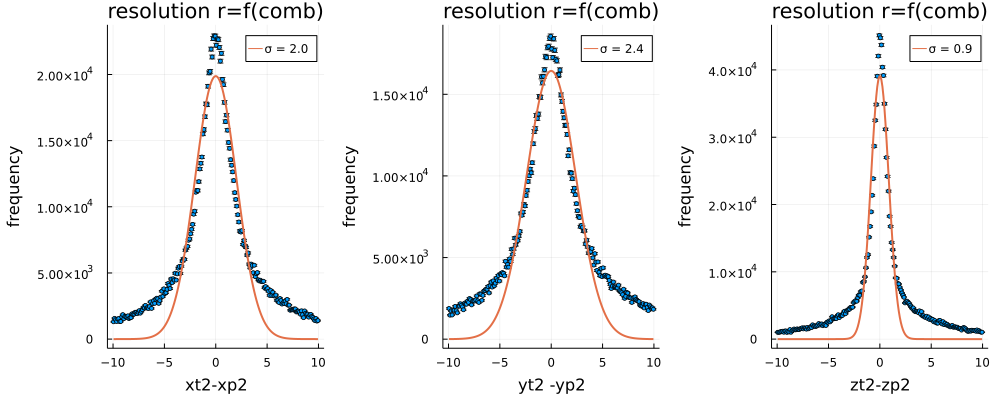

In [71]:
fg,px2 = fitg1(ndf_mask.xt2 - xp2, "xt2-xp2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,py2 = fitg1(ndf_mask.yt2 - yp2, "yt2 -yp2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pz2 = fitg1(ndf_mask.zt2 - zp2, "zt2-zp2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(px2,py2, pz2, "resolution r=f(comb)", joinpath(plot_path, "phistd-res")) 

# TOF

In [72]:
##df_mask = ANema.setunits(ndf_mask);
# This will be formalised probably
# mm columns:
len_cols = [:r1, :r2, :rpred1, :rpred2, :x1, :x2, :xb1, :xb2, :xr1, :xr2,
            :xs, :xt1, :xt2, :y1, :y2, :yb1, :yb2, :yr1, :yr2, :ys, :yt1,             :yt2, :z1, :z2, :zb1, :zb2, :zr1, :zr2, :zs, :zt1, :zt2]
transform!(ndf_mask, len_cols .=> (x -> x * mm), renamecols=false)
# ns cols:
time_cols = [:t1, :t2, :ta1, :ta2, :tr1, :tr2]
transform!(ndf_mask, time_cols .=> (x -> x * ns), renamecols=false)

,corrzphi1,corrzphi2,nsipm1,nsipm2,phistd1,phistd2,phot1,phot2,q1
,Float64,Float64,Int64,Int64,Float64,Float64,Bool,Bool,Float64
1,0.0468146,-0.00969903,403,362,0.112965,0.109308,1,1,2114.0
2,0.215825,0.00255235,216,256,0.116769,0.0761744,0,1,1986.0
3,-0.341033,0.187138,145,167,0.0682815,0.0638744,0,0,2014.0
4,-0.00704946,0.0871966,400,348,0.101944,0.104981,0,1,2104.0
5,0.153247,0.515556,231,48,0.0776287,0.0345989,0,1,2108.0
6,-0.0299562,-0.0244119,281,194,0.0859842,0.0696792,0,0,2185.0
7,0.201815,0.0551596,209,328,0.0827954,0.100583,0,0,2014.0
8,0.547628,-0.418525,49,64,0.0435406,0.0893716,0,1,1974.0
9,0.183237,0.00627131,289,53,0.0838764,0.0494898,0,0,1976.0


First photon, position true: FWHM1 = 438.694 FWHM2 =  55.880

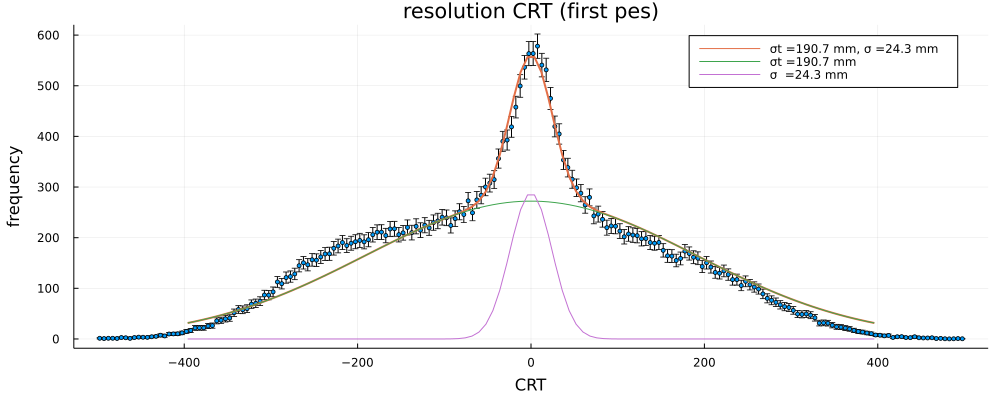

In [73]:
dt = ANema.crt(ndf_mask,  ANema.dtfirst, ANema.postrue)
fg, p = fitg2(dt, "CRT", 200, -500.0, 500.0, 
                      xg1min=-400.0, xg1max=-50.0, 
                      xg2min=-50.0,  xg2max =50.0, 
                      xgmin =-400.0, xgmax  =400.0)
@printf "First photon, position true: FWHM1 = %7.3f FWHM2 = %7.3f" 2.3*fg.std[1] 2.3*fg.std[2]
ANema.plot_and_save(p, "resolution CRT (first pes)", joinpath(plot_path, "CRT-first"))

fastest photoelectron, position reco: FWHM = 392.624

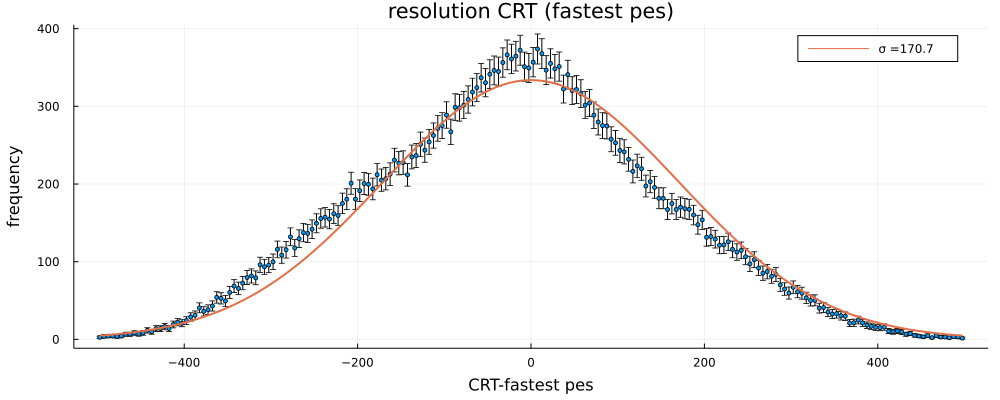

In [74]:
dt = ANema.crt(ndf_mask, ANema.dtminimum, ANema.postrue)
fg,p = fitg1(dt, "CRT-fastest pes", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes)", joinpath(plot_path, "CRT-fastest"))

In [199]:
dt = ANema.crt(ndf_mask,  ANema.dtminimum, ANema.posrecall)
fg,p = fitg1(dt, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes, reco pos)", joinpath(plot_path, "CRT-fastest-reco"))

LoadError: ArgumentError: column name :r1x not found in the data frame; existing most similar names are: :r1